In [38]:
import pandas as pd
from os import path

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_docs as tfdocs
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from scipy.signal import resample

#adding local modules
import sys
module_path = path.abspath(path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import load_biodarw #todo move to python package
from preprocess.biodarw_feature_extraction import extract_residues, extract_features_of
from properties import properties

coefficients=17
mini_batch_size=8

In [2]:
#Load meta data
metadf=pd.read_csv(path.join("/data/elekin/doc","metadata-202106-v1.csv"),index_col=0)
metadf.head(16)

,abs_path,relative_path,temblor,Sexo,TRS,age,level
name,,,,,,,
C01_1,/data/elekin/data/origin/ethw/Controles30jun14...,C01/session00002/u00003s00002_hw000011.svc,no,F,0,27,0
C01_2,/data/elekin/data/origin/ethw/Controles30jun14...,C01/session00002/u00003s00002_hw000012.svc,no,F,0,27,0
C02_1,/data/elekin/data/origin/ethw/Controles30jun14...,C02/session00001/u00004s00001_hw000011.svc,no,F,0,29,0
C02_2,/data/elekin/data/origin/ethw/Controles30jun14...,C02/session00001/u00004s00001_hw000012.svc,no,F,0,29,0
C03_1,/data/elekin/data/origin/ethw/Controles30jun14...,C03/session00001/u00005s00001_hw000011.svc,no,F,0,32,0
C03_2,/data/elekin/data/origin/ethw/Controles30jun14...,C03/session00001/u00005s00001_hw000012.svc,no,F,0,32,0
C04_1,/data/elekin/data/origin/ethw/Controles30jun14...,C04/session00001/u00006s00001_hw000011.svc,no,M,0,32,0
C04_2,/data/elekin/data/origin/ethw/Controles30jun14...,C04/session00001/u00006s00001_hw000012.svc,no,M,0,32,0
C05_1,/data/elekin/data/origin/ethw/Controles30jun14...,C05/session00001/u00007s00001_hw000011.svc,no,M,0,22,0


In [3]:
#Load data
dataset=load_biodarw(metadf.index, metadf['abs_path'])

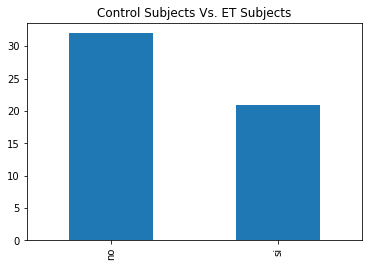

In [4]:
#Loading labels based on clinic, residues and features from residues.
labels = metadf['temblor']
ax = labels.value_counts().plot.bar(title='Control Subjects Vs. ET Subjects')

In [5]:
rd = dataset.groupby('subject_id').apply(extract_residues, c=coefficients).apply(resample, num=4096)
rd_rd = pd.DataFrame(rd.tolist(), index=rd.index)
rd_rd.head(16)

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
subject_id,,,,,,,,,,,,,,,,,,,,,
C01_1,2616.494977,2603.574851,2615.779950,2624.033204,2618.051843,2611.919996,2615.301600,2619.929647,2617.352375,2612.779288,...,2710.031486,2708.866591,2713.750870,2716.039478,2709.186923,2704.188985,2713.697295,2724.906692,2709.008099,2661.917377
C01_2,4167.778042,4191.983504,4167.788500,4153.906841,4166.734844,4175.513013,4165.897571,4158.578102,4165.571963,4171.245721,...,3992.037378,3998.828241,3992.366378,3983.943586,3992.937826,4005.511142,3991.993073,3968.344815,3992.445994,4079.987502
C02_1,2316.313494,2255.653513,2288.636990,2338.955456,2346.077098,2316.014762,2294.409265,2305.277421,2328.560089,2333.421467,...,2656.925026,2687.498288,2694.523426,2676.595863,2671.904250,2713.305348,2774.437250,2777.527899,2668.200991,2480.439478
C02_2,3810.389867,3799.250359,3809.251681,3812.917888,3804.898521,3800.272263,3803.247152,3803.214081,3796.953952,3792.505681,...,3888.587302,3884.934062,3886.722941,3891.707131,3889.247678,3882.607761,3887.016589,3898.511396,3889.736159,3850.682162
C03_1,2267.141506,2249.673932,2266.871954,2277.587148,2268.662020,2260.977152,2266.722216,2272.881263,2268.971102,2263.949978,...,2361.801503,2358.315537,2365.294818,2371.338872,2364.812912,2360.305239,2378.474975,2402.913606,2389.741610,2329.063761
C03_2,3811.550394,3809.392096,3812.793686,3814.089044,3812.806864,3813.263648,3815.586251,3816.831202,3816.804984,3816.932940,...,3831.898004,3831.623686,3831.343367,3832.380240,3832.652731,3831.082385,3831.142307,3833.601195,3831.787894,3821.906755
C04_1,2514.144329,2512.230656,2514.624837,2515.053243,2513.576047,2513.685876,2514.675936,2514.300085,2513.653502,2514.138691,...,2521.099771,2520.918384,2520.489926,2521.706256,2522.571136,2521.283624,2521.558542,2525.743593,2527.723924,2522.020953
C04_2,3832.845898,3826.680837,3836.820798,3829.918422,3831.296303,3833.640764,3828.979551,3832.515552,3833.491962,3830.931258,...,3894.473115,3891.903663,3894.271819,3894.244339,3891.253381,3896.260209,3892.679320,3890.468637,3902.923123,3880.488017
C05_1,2347.636091,2339.751504,2350.684227,2350.490043,2344.732659,2347.386162,2350.201973,2347.150553,2346.675543,2349.464264,...,2422.373702,2420.083436,2412.710935,2413.069001,2418.294056,2413.879559,2410.047716,2421.093235,2422.210202,2388.035153


In [30]:
rd_fe = rd_rd.apply(extract_features_of, axis='columns')
rd_fe_df = pd.DataFrame(rd_fe.tolist(), index=rd_fe.index)
rd_fe_df.columns = properties.features_names
rd_fe_df.head(10)

,mean_abs_val(L),np.var(L),root_mean_square(L),log_detector(L),wl(L),np.nanstd(L),diff_abs_std(L),higuchi(L),mfl(L),myo(L),...,mp(Pxx),tp(Pxx),meanfreq(L),medfreq(L),std_psd(Pxx),"mmnt(Pxx, order=1)","mmnt(Pxx, order=2)","mmnt(Pxx, order=3)",kurt(Pxx),skw(Pxx)
subject_id,,,,,,,,,,,,,,,,,,,,,
C01_1,2602.815603,1364.507135,6.776014e+06,2.123803e+12,2977.546075,36.939236,1.283325,1.082075,7.998855,0.0,...,2727.682393,5.589021e+06,0.276739,3.730807e-07,60610.057292,0.0,3.673579e+09,8.059958e+15,1439.719440,36.199176
C01_2,4074.441842,1285.863555,1.660236e+07,8.365924e+12,3000.110088,35.858940,1.923338,1.141284,8.006404,0.0,...,2570.471997,5.266897e+06,0.294032,6.032075e-04,40520.410948,0.0,1.641904e+09,2.064673e+15,1145.892789,31.033432
C02_1,2496.116675,1781.279348,6.232380e+06,5.178195e+12,4276.219835,42.205205,4.214377,1.206417,8.360825,0.0,...,3560.820014,7.296120e+06,0.307683,5.253788e-09,50928.778800,0.0,2.593741e+09,3.658466e+15,866.221542,27.695505
C02_2,3852.648277,2767.010752,1.484567e+07,1.619380e+14,3739.691230,52.602384,1.477934,1.050401,8.226758,0.0,...,5531.320664,1.133368e+07,0.289665,6.037906e-04,95167.034342,0.0,9.056764e+09,2.059373e+16,620.665923,23.893258
C03_1,2389.902540,823.506090,5.712458e+06,2.189736e+11,2983.367961,28.696796,1.491047,1.122140,8.000808,0.0,...,1646.208368,3.373081e+06,0.355573,5.025253e-06,31333.924313,0.0,9.818148e+08,1.114865e+15,1465.207915,36.239140
C03_2,3806.192758,1321.691685,1.448843e+07,7.342226e+12,3309.623209,36.355078,1.043939,1.043718,8.104590,0.0,...,2642.093284,5.413649e+06,0.334473,7.626993e-04,63177.141439,0.0,3.991351e+09,1.031325e+16,1768.273273,40.899270
C04_1,2538.551762,1585.830263,6.445831e+06,3.497585e+12,3080.132242,39.822484,1.049289,1.052582,8.032728,0.0,...,3170.112619,6.495561e+06,0.345416,1.308325e-03,86276.633480,0.0,7.443657e+09,2.603957e+16,1732.786809,40.546573
C04_2,3916.122380,1185.963715,1.533720e+07,5.195383e+12,4130.353264,34.437824,1.404320,1.059447,8.326118,0.0,...,2370.769829,4.857707e+06,0.401394,8.578834e-04,30853.993602,0.0,9.519689e+08,5.907791e+14,451.930773,20.113654
C05_1,2417.024809,2050.669819,5.844060e+06,7.943800e+12,4195.184060,45.284322,1.482554,1.059109,8.341692,0.0,...,4099.338007,8.399544e+06,0.340836,8.266841e-04,71440.699791,0.0,5.103774e+09,8.259114e+15,540.337238,22.651468


In [32]:
#Train test split and scale timeseries between 0 and 1
from sklearn.model_selection import train_test_split

labels = (metadf["temblor"] == 'si').astype('int8')
y=labels.values
x_train, x_test, y_train, y_test = train_test_split(rd_fe_df.values, y, test_size=0.33, random_state=42)

In [42]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).take(len(x_train)).batch(mini_batch_size).prefetch(2).cache()
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).take(len(x_test)).batch(mini_batch_size).prefetch(2).cache()
steps_per_epoch = round(len(train_dataset)/mini_batch_size)

for feat, targ in test_dataset.take(10):
    print ('Features test: {}, Target: {}'.format(feat, targ))

for feat, targ in test_dataset.take(10):
    print ('Features train: {}, Target: {}'.format(feat, targ))

print("{0} train batches and {1} test batches of {2} mini batch size and {3} steps per epoch".format(len(train_dataset), 
                                                                              len(test_dataset),
                                                                              mini_batch_size,
                                                                                steps_per_epoch))
test_dataset

Features test: [[2.48878315e+03 3.15086673e+04 6.22555023e+06 3.82885049e+17
  3.03479222e+04 1.77506809e+02 3.33249528e+01 1.53006760e+00
  1.03204833e+01 0.00000000e+00 1.01940558e+07 2.54998537e+10
  1.50100000e+03 0.00000000e+00 0.00000000e+00 4.39659470e+03
  1.61040088e+07 6.29865794e+04 1.29059501e+08 7.95117060e-01
  6.45271046e-01 5.91303553e+05 0.00000000e+00 3.49639891e+11
  3.48588425e+18 3.46660281e+02 1.68609289e+01]
 [2.54459364e+03 3.03485128e+03 6.47799165e+06 4.49357950e+13
  9.04096350e+03 5.50894843e+01 9.21399088e+00 1.14745499e+00
  9.10952103e+00 0.00000000e+00 1.04226556e+07 2.65338538e+10
  2.12800000e+03 0.00000000e+00 0.00000000e+00 3.37431360e+03
  3.11818548e+06 6.06674028e+03 1.24307508e+07 4.33134973e-01
  1.21526051e-03 8.30192593e+04 0.00000000e+00 6.89219741e+09
  1.70708196e+16 1.02785452e+03 2.98344345e+01]
 [4.28775989e+03 5.62535600e+03 1.83905103e+07 4.80845339e+15
  2.09321420e+04 7.50023733e+01 5.44312552e+01 1.69834562e+00
  9.94904115e+00 0.00

<CacheDataset shapes: ((None, 27), (None,)), types: (tf.float64, tf.int8)>